In [54]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

## 相位噪声模拟  
时间分辨率1us，采样率1MHz，模拟时间1s  
用布朗运动模拟相位噪声

      phase speed      phase
Mean    -0.000003 -10.174578
Std      0.013941   3.978187
Var      0.000194  15.825972


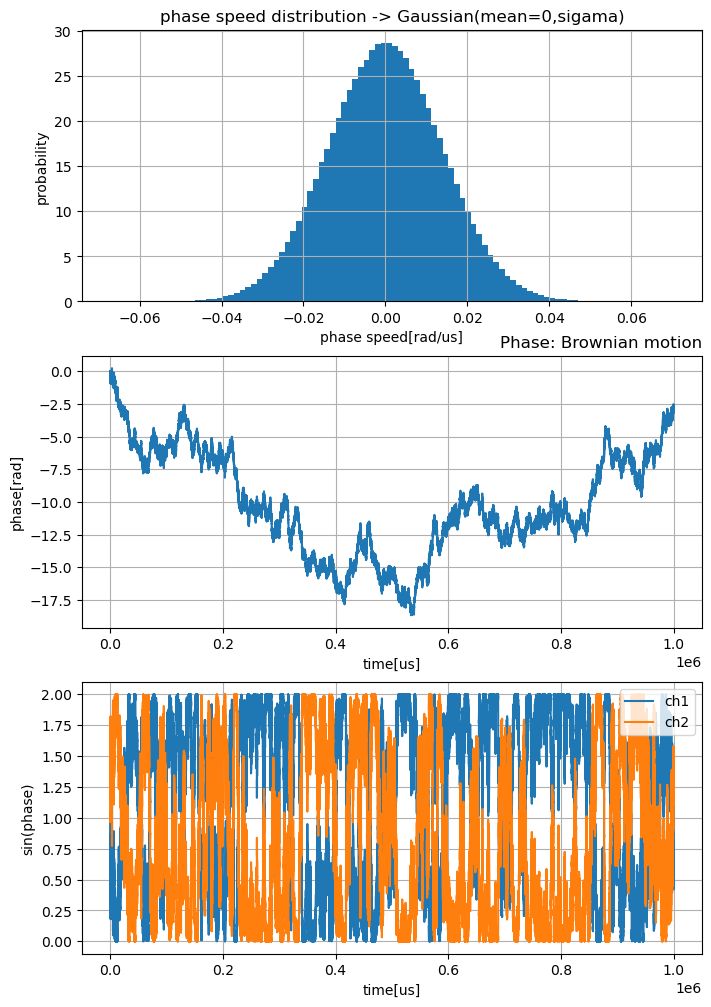

In [55]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

如果相位噪声满足独立随机分布，那么用var评估比较好，因为其关于时间（采样点）是线性的；

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import os
import plotly.express as px

import allantools

def get_std(t,y):
    """
    输入：t,y为时间（s）和相位序列
    输出：['std':[tau,std],
            'std_ms':(0.1ms,1ms)]为时间序列和标准差序列
    """
    tau=allantools.tau_generator(y,rate=1,taus="decade")[-1].astype('int')
    fs=1/(t[1]-t[0])
    x0,x1=0.9e-4,1e-1
    tau=tau[(tau/fs>=x0)&(tau/fs<=x1)]
    std_mean=[]
    std=[]
    mean=[]
    for tau_ in tau:
        y_=np.reshape(y[:len(y)//tau_*tau_],(-1,tau_))
        y_=np.mean(y_,axis=1)
        std_mean.append(np.std(np.diff(y_[::1])))
        # std.append(np.var(np.diff(y[::tau_])))
        # mean.append(np.mean(np.diff(y[::tau_])))
    ms_std=[]
    for tau_ in [1e-4*fs,1e-3*fs]:
        try:
            y_=np.reshape(y[:len(y)//int(tau_)*int(tau_)],(-1,int(tau_)))
            y_=np.mean(y_,axis=1)
            ms_std.append((tau_/fs,np.std(np.diff(y_[::1]))))
        except:
            ms_std.append((tau_/fs,np.nan))

    # 将列表转换为 NumPy 数组
    std_mean = np.array(std_mean)
    tau_fs = tau / fs

    plt.plot(tau_fs, std_mean, label='std')
    # plt.plot(tau_fs, std, label='std')
    plt.xlim(x0,x1)
    plt.legend()
    plt.xlabel('tau (s)')
    plt.ylabel('diff phase std (deg)')
    plt.xscale('log')
    plt.yscale('log')
    return {'std':[tau_fs,std_mean],
            'std_ms':ms_std}


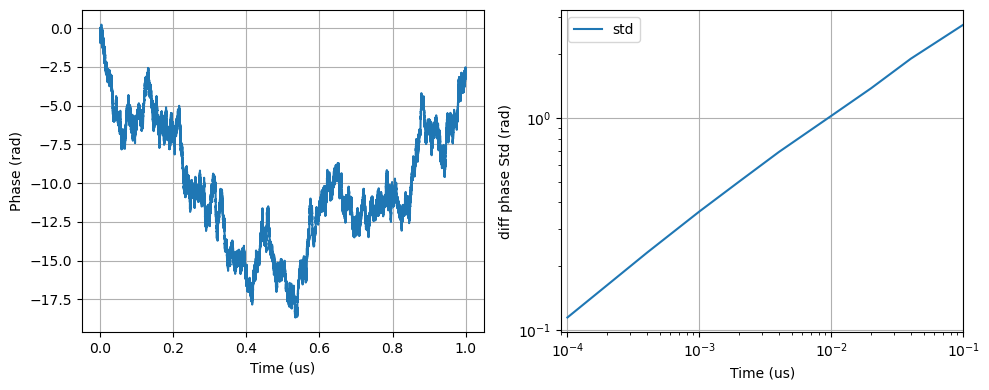

In [57]:
t=time_axis*1e-6
y=np.cumsum(phase_speed)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(t,y)
plt.xlabel('Time (us)')
plt.ylabel('Phase (rad)')
plt.grid()
plt.subplot(122)
get_std(t,y)
plt.xlabel('Time (us)')
plt.ylabel('diff phase Std (rad)')
plt.grid()
plt.tight_layout()

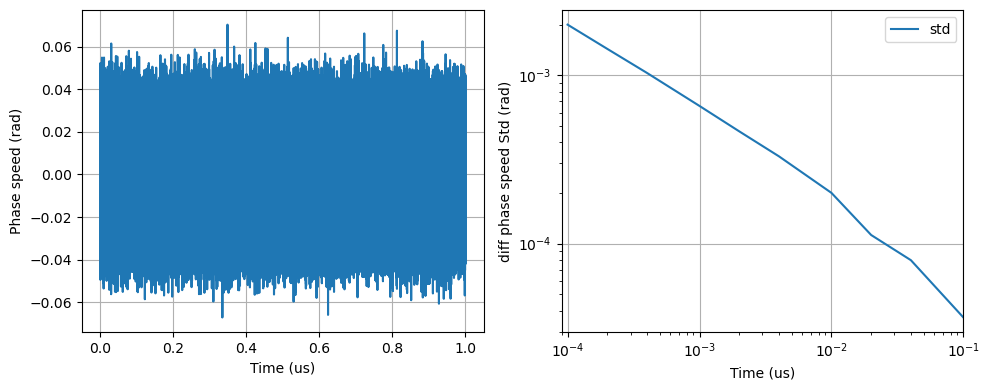

In [59]:
t=time_axis*1e-6
y=(phase_speed)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(t,y)
plt.xlabel('Time (us)')
plt.ylabel('Phase speed (rad)')
plt.grid()
plt.subplot(122)
get_std(t,y)
plt.xlabel('Time (us)')
plt.ylabel('diff phase speed Std (rad)')
plt.grid()
plt.tight_layout()